# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [51]:
#### from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([
    # TODO Task 1:  Training transofrmations
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
    ]),
    'test': transforms.Compose([
    # TODO Task 1:  Test transofrmations
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   
    ])
}

# Load CIFAR10
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256, shuffle=(x=='train'), num_workers=32) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

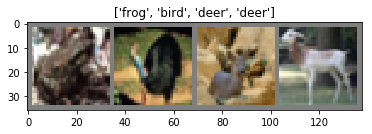

In [2]:
# TODO Task 1:  Run this cell and try to understand the output of each step

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [104]:
print(out.shape)

torch.Size([3, 36, 138])


## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) as follows in the Jupyter Notebook:
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) as follows in the Jupyter Notebook:
```
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

## Task 2 Report 
<p style="color:salmon">1. FcNet: Acc: 0.5372; Training complete in 5m 38s 
    
<p style="color:salmon">2. ConvNet: Acc: 0.6541; Training complete in 5m 54s</p> 



### Model training code (do not modify except for plotting the loss curve)

In [52]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()
    loss_values = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_values.append(epoch_loss)

    print()
    ## For plotting the loss curve
    plt.figure()
    plt.plot(range(len(loss_values)), loss_values)
    plt.xlabel('epochs')
    plt.ylabel('loss value')
    plt.show()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model

### 1) FC Network

In [11]:
# 1) Define a Fully Connected Neural Network
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers 
        self.layers = nn.Sequential(
            nn.Linear(in_features=3072, out_features=1024, bias=True), nn.ReLU(), 
            nn.Linear(in_features=1024, out_features=400, bias=True), nn.ReLU(), 
            nn.Linear(in_features=400, out_features=84, bias=True), nn.ReLU(), 
            nn.Linear(in_features=84, out_features=10, bias=True),
                )

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        b,channel,weight,height = x.shape
        x = self.layers(x.view(b,-1))
        return x

model_ft = FcNet()
model_ft = model_ft.to(device)
print(model_ft)

FcNet(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=84, bias=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)


Epoch 0/2
----------
train Loss: 1.6925 Acc: 0.3943
Epoch 1/2
----------
train Loss: 1.4276 Acc: 0.4924
Epoch 2/2
----------
train Loss: 1.3046 Acc: 0.5372



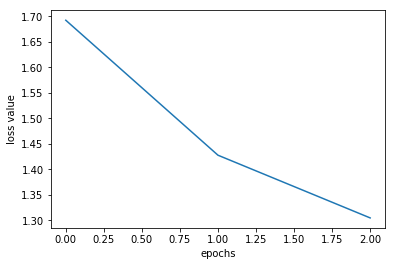

Training complete in 5m 38s


In [12]:
# Training for 3 Epochs and recording the training time and accuracy
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=3)

### 2) CNN

In [13]:
# 2) Define a Convolutional Neural Network 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO Task 2:  Define the CNN layers 
        self.convs = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)), nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), nn.ReLU(), 
            nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), nn.ReLU(), 
            
               )
        self.fcs = nn.Sequential(
            nn.Linear(in_features=400, out_features=120, bias=True), nn.ReLU(), 
            nn.Linear(in_features=120, out_features=84, bias=True), nn.ReLU(), 
            nn.Linear(in_features=84, out_features=10, bias=True), nn.ReLU(), 
                )

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = self.convs(x)
        b,c,w,h = x.shape
        x = self.fcs(x.view(b,-1))        
        return x

model_ft = ConvNet()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet(
  (convs): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fcs): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): ReLU()
  )
)


Epoch 0/2
----------
train Loss: 1.1018 Acc: 0.6093
Epoch 1/2
----------
train Loss: 1.0316 Acc: 0.6371
Epoch 2/2
----------
train Loss: 0.9774 Acc: 0.6541



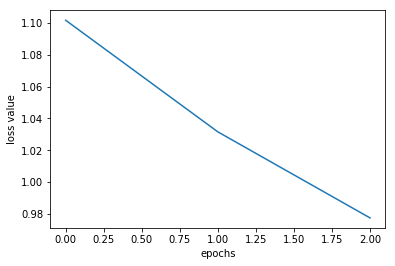

Training complete in 5m 54s


In [23]:
# Train the ConvNet for 3 epoches and record the training time and accuracy
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=3)

## Task 3: Design Your Network I (20 points)
Define your own Convolutional Network (MyNet) starting from the configuration in Task 2.2. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

1. Increase the number of layers: Modify the number of convolutional layers in the network.
2. Increase the number of filters: Modify the number of filters in each convolutional layer of the network. 
3. Modify the filter sizes in each convolutional layer. Experiment with different filter sizes (3x3, 5x5 and 7x7).

## Task 3 Report
<p style="color:salmon">MyNet: Training Accuracy: 0.9905; Test Accuracy 0.7933</p> 
From the difference of the training accuracy and the test accuracy, there is overfitting in my model. So I reduced the number of conv layers from 5 to 4 in task 4.

In [46]:
# Design my own network here with above-mentioned modifications 
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # 5 conv layers and 3 linear layers -- AlexNet
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fcs = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096), nn.ReLU(),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Linear(4096, 10)
        )
            
    def forward(self, x):
        x = self.convs(x)
        # print(x.shape)
        b,c,w,h=x.shape
        x = self.fcs(x.view(b,-1))
        return x
    
model_mynet_ft = MyNet()
model_mynet_ft = model_mynet_ft.to(device)


Epoch 0/24
----------
train Loss: 1.7312 Acc: 0.3514
Epoch 1/24
----------
train Loss: 1.1993 Acc: 0.5710
Epoch 2/24
----------
train Loss: 0.9062 Acc: 0.6799
Epoch 3/24
----------
train Loss: 0.7241 Acc: 0.7463
Epoch 4/24
----------
train Loss: 0.5817 Acc: 0.7952
Epoch 5/24
----------
train Loss: 0.4563 Acc: 0.8388
Epoch 6/24
----------
train Loss: 0.3387 Acc: 0.8825
Epoch 7/24
----------
train Loss: 0.2503 Acc: 0.9144
Epoch 8/24
----------
train Loss: 0.1819 Acc: 0.9369
Epoch 9/24
----------
train Loss: 0.1397 Acc: 0.9521
Epoch 10/24
----------
train Loss: 0.1157 Acc: 0.9612
Epoch 11/24
----------
train Loss: 0.0950 Acc: 0.9694
Epoch 12/24
----------
train Loss: 0.0744 Acc: 0.9754
Epoch 13/24
----------
train Loss: 0.0668 Acc: 0.9790
Epoch 14/24
----------
train Loss: 0.0499 Acc: 0.9840
Epoch 15/24
----------
train Loss: 0.0513 Acc: 0.9836
Epoch 16/24
----------
train Loss: 0.0524 Acc: 0.9834
Epoch 17/24
----------
train Loss: 0.0400 Acc: 0.9874
Epoch 18/24
----------
train Loss: 0.0

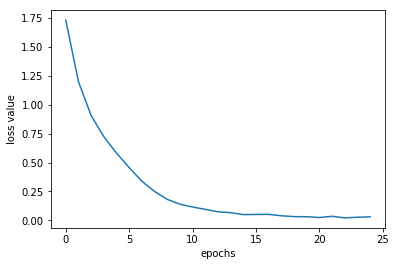

Training complete in 228m 3s


In [47]:
# Train the Network for 10 epoches
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_mynet_ft.parameters(), lr=0.001, momentum=0.9)
model_mynet_ft = train_model(model_mynet_ft, criterion, optimizer_ft, num_epochs=10)

In [126]:
test_model(model_mynet_ft)

test Acc: 0.7933
Testing complete in 0m 2s


## Task 4: Design Your Network II (20 points)
Keeping the best settings of Task 3, use **Dropout** in fully connected layers and Batch Normalization (choose a suitable batch size) in convolutional layers. Record the training accuracy of the last epoch and test accuracy in your report.

## Task 4 Report
<p style="color:salmon">MyNet_1: Training Accuracy: 0.9682; Test Accuracy 0.7933</p> 


### Design Your Network

In [80]:
# Define a Convolutional Neural Network
class MyNet_1(nn.Module):
    def __init__(self):
        super(MyNet_1, self).__init__()
        # batchnormalization on convs of AlexNet
        # dropout on fcs of AlexNet
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=2), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.BatchNorm2d(192), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fcs = nn.Sequential(
            nn.Dropout(), nn.Linear(256 * 2 * 2, 1024), nn.ReLU(),
            nn.Dropout(), nn.Linear(1024, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
            
    def forward(self, x):
        x = self.convs(x)
        b = x.shape[0]
        x = self.fcs(x.view(b,-1))
        return x


Epoch 0/24
----------
train Loss: 1.6338 Acc: 0.3929
Epoch 1/24
----------
train Loss: 1.1325 Acc: 0.5943
Epoch 2/24
----------
train Loss: 0.9416 Acc: 0.6649
Epoch 3/24
----------
train Loss: 0.8222 Acc: 0.7128
Epoch 4/24
----------
train Loss: 0.7321 Acc: 0.7431
Epoch 5/24
----------
train Loss: 0.6484 Acc: 0.7738
Epoch 6/24
----------
train Loss: 0.5902 Acc: 0.7933
Epoch 7/24
----------
train Loss: 0.5305 Acc: 0.8159
Epoch 8/24
----------
train Loss: 0.4800 Acc: 0.8340
Epoch 9/24
----------
train Loss: 0.4363 Acc: 0.8481
Epoch 10/24
----------
train Loss: 0.3969 Acc: 0.8627
Epoch 11/24
----------
train Loss: 0.3514 Acc: 0.8780
Epoch 12/24
----------
train Loss: 0.3215 Acc: 0.8885
Epoch 13/24
----------
train Loss: 0.2857 Acc: 0.8996
Epoch 14/24
----------
train Loss: 0.2577 Acc: 0.9104
Epoch 15/24
----------
train Loss: 0.2288 Acc: 0.9201
Epoch 16/24
----------
train Loss: 0.2061 Acc: 0.9286
Epoch 17/24
----------
train Loss: 0.1840 Acc: 0.9367
Epoch 18/24
----------
train Loss: 0.1

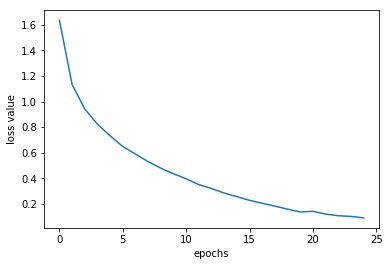

Training complete in 19m 16s


In [87]:
model_mynet_1_ft = MyNet_1()
model_mynet_1_ft = model_mynet_1_ft.to(device)
criterion = nn.CrossEntropyLoss()

# TODO Task 5: Optimizer
optimizer_ft = optim.SGD(model_mynet_1_ft.parameters(), lr=0.01, momentum=0.9)
## Train and evaluate
model_mynet_1_ft = train_model(model_mynet_1_ft, criterion, optimizer_ft, num_epochs=25)

In [125]:
test_model(model_mynet_1_ft)

test Acc: 0.7933
Testing complete in 0m 2s


## Task 5: The Optimizer (20 points)
Keeping the best settings of Task 4, use 3 different optimizers (SGD, ADAM and RMSProp) with 3 different learning rates (0.001, 0.01, 0.1) . Plot the loss curves (Training loss vs Training step) for each case.

## Task 5 Report
<p style="color:salmon">Please kindly find the 9 loss curves in the following part. From the results, we can see that using SGD our model can converge with different learning rates(0.001, 0.01, 0.1) while ADAM and RMSProp can only perform well with certain learning rates.</p> 


### Testing the Accuracy

In [75]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

In [ ]:
test_model(model_ft)

learning rate is 0.001
Epoch 0/9
----------
train Loss: 2.1711 Acc: 0.2017
Epoch 1/9
----------
train Loss: 1.7300 Acc: 0.3489
Epoch 2/9
----------
train Loss: 1.4795 Acc: 0.4463
Epoch 3/9
----------
train Loss: 1.3097 Acc: 0.5194
Epoch 4/9
----------
train Loss: 1.1808 Acc: 0.5724
Epoch 5/9
----------
train Loss: 1.0791 Acc: 0.6155
Epoch 6/9
----------
train Loss: 1.0039 Acc: 0.6418
Epoch 7/9
----------
train Loss: 0.9317 Acc: 0.6688
Epoch 8/9
----------
train Loss: 0.8744 Acc: 0.6909
Epoch 9/9
----------
train Loss: 0.8248 Acc: 0.7074



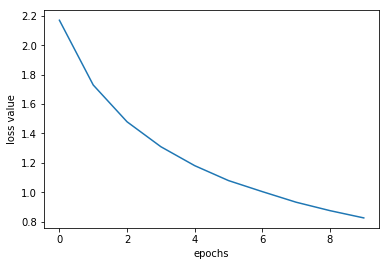

Training complete in 8m 13s
test Acc: 0.6485
Testing complete in 0m 4s
learning rate is 0.01
Epoch 0/9
----------
train Loss: 1.6310 Acc: 0.3898
Epoch 1/9
----------
train Loss: 1.1323 Acc: 0.5921
Epoch 2/9
----------
train Loss: 0.9315 Acc: 0.6690
Epoch 3/9
----------
train Loss: 0.8011 Acc: 0.7186
Epoch 4/9
----------
train Loss: 0.7081 Acc: 0.7547
Epoch 5/9
----------
train Loss: 0.6395 Acc: 0.7777
Epoch 6/9
----------
train Loss: 0.5742 Acc: 0.8008
Epoch 7/9
----------
train Loss: 0.5189 Acc: 0.8195
Epoch 8/9
----------
train Loss: 0.4645 Acc: 0.8374
Epoch 9/9
----------
train Loss: 0.4304 Acc: 0.8510



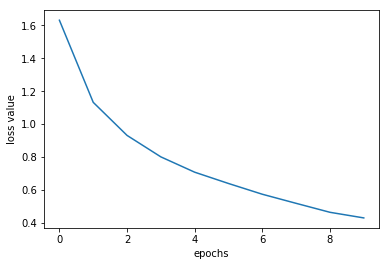

Training complete in 8m 55s
test Acc: 0.7679
Testing complete in 0m 5s
learning rate is 0.1
Epoch 0/9
----------
train Loss: 1.5847 Acc: 0.4107
Epoch 1/9
----------
train Loss: 1.1603 Acc: 0.5879
Epoch 2/9
----------
train Loss: 0.9348 Acc: 0.6747
Epoch 3/9
----------
train Loss: 0.8060 Acc: 0.7234
Epoch 4/9
----------
train Loss: 0.6976 Acc: 0.7612
Epoch 5/9
----------
train Loss: 0.6161 Acc: 0.7891
Epoch 6/9
----------
train Loss: 0.5545 Acc: 0.8094
Epoch 7/9
----------
train Loss: 0.4945 Acc: 0.8297
Epoch 8/9
----------
train Loss: 0.4386 Acc: 0.8495
Epoch 9/9
----------
train Loss: 0.4047 Acc: 0.8617



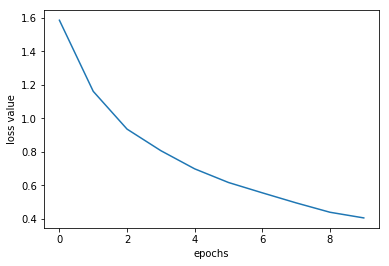

Training complete in 8m 29s
test Acc: 0.7936
Testing complete in 0m 5s


In [79]:
# Optimizer 1 : SGD
for lr in [0.001, 0.01, 0.1]:
    model_sgd_ft = MyNet_1()
    model_sgd_ft = model_sgd_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model_sgd_ft.parameters(), lr=lr, momentum=0.9)
    print("learning rate is {}".format(lr))
    model_sgd_ft = train_model(model_sgd_ft, criterion, optimizer_ft, num_epochs=10)
    test_model(model_sgd_ft)
    print("-------------------------------")

learning rate is 0.001
Epoch 0/9
----------
train Loss: 1.4077 Acc: 0.4840
Epoch 1/9
----------
train Loss: 0.9955 Acc: 0.6490
Epoch 2/9
----------
train Loss: 0.8099 Acc: 0.7186
Epoch 3/9
----------
train Loss: 0.6843 Acc: 0.7641
Epoch 4/9
----------
train Loss: 0.5993 Acc: 0.7949
Epoch 5/9
----------
train Loss: 0.5253 Acc: 0.8181
Epoch 6/9
----------
train Loss: 0.4625 Acc: 0.8405
Epoch 7/9
----------
train Loss: 0.4017 Acc: 0.8607
Epoch 8/9
----------
train Loss: 0.3544 Acc: 0.8767
Epoch 9/9
----------
train Loss: 0.3064 Acc: 0.8933



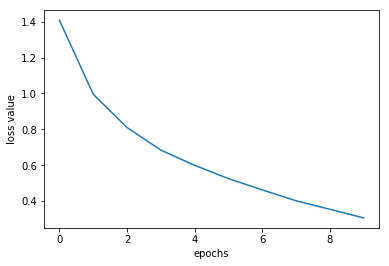

Training complete in 8m 21s
test Acc: 0.7621
Testing complete in 0m 6s
-------------------------------
learning rate is 0.01
Epoch 0/9
----------
train Loss: 1.9821 Acc: 0.2044
Epoch 1/9
----------
train Loss: 1.6828 Acc: 0.3441
Epoch 2/9
----------
train Loss: 1.3856 Acc: 0.4848
Epoch 3/9
----------
train Loss: 1.1691 Acc: 0.5885
Epoch 4/9
----------
train Loss: 1.0225 Acc: 0.6495
Epoch 5/9
----------
train Loss: 0.9018 Acc: 0.6943
Epoch 6/9
----------
train Loss: 0.8211 Acc: 0.7255
Epoch 7/9
----------
train Loss: 0.7475 Acc: 0.7513
Epoch 8/9
----------
train Loss: 0.6853 Acc: 0.7734
Epoch 9/9
----------
train Loss: 0.6324 Acc: 0.7913



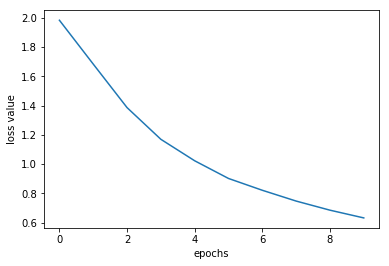

Training complete in 8m 18s
test Acc: 0.7596
Testing complete in 0m 3s
-------------------------------
learning rate is 0.1
Epoch 0/9
----------
train Loss: 8.9406 Acc: 0.0981
Epoch 1/9
----------
train Loss: 2.3057 Acc: 0.1009
Epoch 2/9
----------
train Loss: 2.3060 Acc: 0.0997
Epoch 3/9
----------
train Loss: 2.3064 Acc: 0.0988
Epoch 4/9
----------
train Loss: 2.3065 Acc: 0.0991
Epoch 5/9
----------
train Loss: 2.3060 Acc: 0.0982
Epoch 6/9
----------
train Loss: 2.3079 Acc: 0.1020
Epoch 7/9
----------
train Loss: 2.3068 Acc: 0.1003
Epoch 8/9
----------
train Loss: 2.3066 Acc: 0.0981
Epoch 9/9
----------
train Loss: 2.3083 Acc: 0.0999



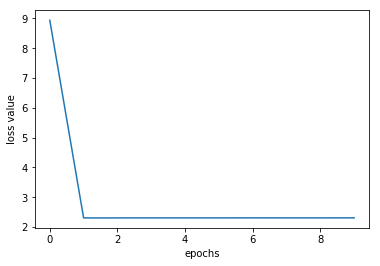

Training complete in 7m 26s
test Acc: 0.1000
Testing complete in 0m 5s
-------------------------------


In [83]:
# Optimizer 2 : ADAM
for lr in [0.001, 0.01, 0.1]:
    model_adam_ft = MyNet_1()
    model_adam_ft = model_adam_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    print("learning rate is {}".format(lr))
    optimizer_ft = optim.Adam(model_adam_ft.parameters(), lr=lr)
    model_adam_ft = train_model(model_adam_ft, criterion, optimizer_ft, num_epochs=10)
    test_model(model_adam_ft)
    print("-------------------------------")

learning rate is 0.001
Epoch 0/9
----------
train Loss: 1.9627 Acc: 0.2310
Epoch 1/9
----------
train Loss: 1.5734 Acc: 0.4004
Epoch 2/9
----------
train Loss: 1.3268 Acc: 0.5119
Epoch 3/9
----------
train Loss: 1.1503 Acc: 0.5931
Epoch 4/9
----------
train Loss: 1.0095 Acc: 0.6504
Epoch 5/9
----------
train Loss: 0.9176 Acc: 0.6868
Epoch 6/9
----------
train Loss: 0.8430 Acc: 0.7154
Epoch 7/9
----------
train Loss: 0.7721 Acc: 0.7406
Epoch 8/9
----------
train Loss: 0.7237 Acc: 0.7581
Epoch 9/9
----------
train Loss: 0.6636 Acc: 0.7767



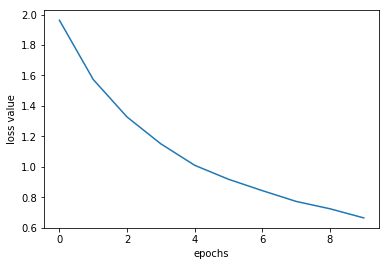

Training complete in 7m 40s
test Acc: 0.7322
Testing complete in 0m 3s
------------------------------
learning rate is 0.01
Epoch 0/9
----------
train Loss: 11.9233 Acc: 0.1008
Epoch 1/9
----------
train Loss: 2.3065 Acc: 0.1007
Epoch 2/9
----------
train Loss: 2.3075 Acc: 0.1014
Epoch 3/9
----------
train Loss: 2.3067 Acc: 0.0990
Epoch 4/9
----------
train Loss: 2.3066 Acc: 0.0987
Epoch 5/9
----------
train Loss: 2.3206 Acc: 0.1003
Epoch 6/9
----------
train Loss: 2.3105 Acc: 0.0979
Epoch 7/9
----------
train Loss: 2.3075 Acc: 0.0993
Epoch 8/9
----------
train Loss: 2.3072 Acc: 0.1008
Epoch 9/9
----------
train Loss: 2.3070 Acc: 0.0984



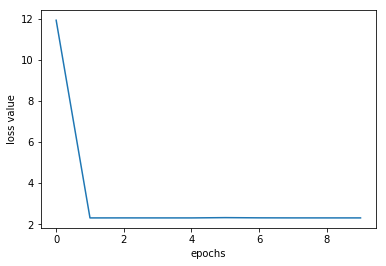

Training complete in 7m 1s
test Acc: 0.1000
Testing complete in 0m 6s
------------------------------
learning rate is 0.1
Epoch 0/9
----------
train Loss: 52573.0341 Acc: 0.0993
Epoch 1/9
----------
train Loss: 2.7259 Acc: 0.1021
Epoch 2/9
----------
train Loss: 2.3310 Acc: 0.1037
Epoch 3/9
----------
train Loss: 153.3847 Acc: 0.1016
Epoch 4/9
----------
train Loss: 2.9189 Acc: 0.0995
Epoch 5/9
----------
train Loss: 2.3633 Acc: 0.1031
Epoch 6/9
----------
train Loss: 2.3311 Acc: 0.1013
Epoch 7/9
----------
train Loss: 2.3406 Acc: 0.0991
Epoch 8/9
----------
train Loss: 2.3310 Acc: 0.1029
Epoch 9/9
----------
train Loss: 2.3301 Acc: 0.0993



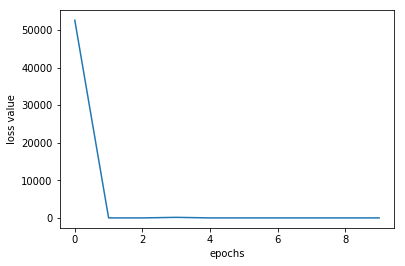

Training complete in 6m 59s
test Acc: 0.1000
Testing complete in 0m 6s
------------------------------


In [86]:
# Optimizer 3 : RMSprop
for lr in [0.001, 0.01, 0.1]:
    model_rms_ft = MyNet_1()
    model_rms_ft = model_rms_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft =  optim.RMSprop(model_rms_ft.parameters(), lr=lr, momentum=0.9)
    print("learning rate is {}".format(lr))
    model_rms_ft = train_model(model_rms_ft, criterion, optimizer_ft, num_epochs=10)
    test_model(model_rms_ft)
    print("-"*30)

### Display model predictions

In [101]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

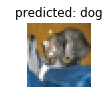

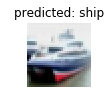

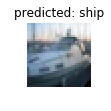

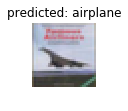

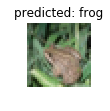

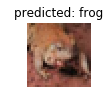

In [102]:
display_predictions(model_mynet_1_ft)

## Task 6: Visualization (10 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

## Save the Feature Maps

In [ ]:
# TODO Task 6: Visualization

In [88]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [133]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg')
model_mynet_1_ft.eval()
with torch.no_grad():
    model_mynet_1_ft(inputs)

In [90]:
class MyNet_1(nn.Module):
    def __init__(self):
        super(MyNet_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=2)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.map = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Sequential(            
            nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.BatchNorm2d(192), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.BatchNorm2d(384), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fcs = nn.Sequential(
            nn.Dropout(), nn.Linear(256 * 2 * 2, 1024), nn.ReLU(),
            nn.Dropout(), nn.Linear(1024, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
            
    def forward(self, x):
        x = self.map(self.relu(self.bn(self.conv1(x))))
        self.featuremap1 = x       
        x = self.conv2(x)
        self.featuremap2 = x
        b = x.shape[0]
        x = self.fcs(x.view(b,-1))
        return x

    

Epoch 0/9
----------
train Loss: 1.6306 Acc: 0.3900
Epoch 1/9
----------
train Loss: 1.1299 Acc: 0.5950
Epoch 2/9
----------
train Loss: 0.9382 Acc: 0.6692
Epoch 3/9
----------
train Loss: 0.7973 Acc: 0.7178
Epoch 4/9
----------
train Loss: 0.7099 Acc: 0.7516
Epoch 5/9
----------
train Loss: 0.6283 Acc: 0.7806
Epoch 6/9
----------
train Loss: 0.5652 Acc: 0.8043
Epoch 7/9
----------
train Loss: 0.5111 Acc: 0.8211
Epoch 8/9
----------
train Loss: 0.4702 Acc: 0.8358
Epoch 9/9
----------
train Loss: 0.4170 Acc: 0.8549



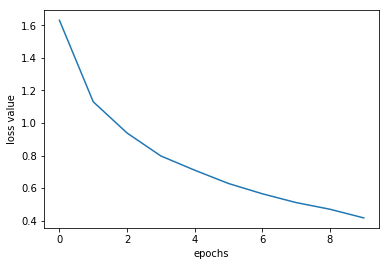

Training complete in 8m 15s


In [92]:
model_mynet_1_ft = MyNet_1()
model_mynet_1_ft = model_mynet_1_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_mynet_1_ft.parameters(), lr=0.01, momentum=0.9)
model_mynet_1_ft = train_model(model_mynet_1_ft, criterion, optimizer_ft, num_epochs=10)

In [134]:
# Model_ft.featuremap1 and model_ft.featuremap2 should be the first and the last feature maps.
# Add model_ft.featuremap1 and model_ft.featuremap2 at suitable places in your network

feature_ouput1 = model_mynet_1_ft.featuremap1.transpose(1,0).cpu()
feature_ouput2 = model_mynet_1_ft.featuremap2.transpose(1,0).cpu()

In [117]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [135]:
print(feature_ouput1.shape)

torch.Size([64, 1, 14, 14])


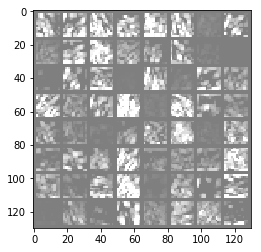

In [136]:
out = torchvision.utils.make_grid(feature_ouput1)
feature_imshow(out)

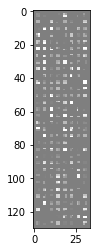

In [138]:
out = torchvision.utils.make_grid(feature_ouput2)
feature_imshow(out)